# Question Generation For Retrieval Evaluation

MLflow provides an advanced framework for constructing Retrieval-Augmented Generation (RAG) models.
RAG is a cutting edge approach that combines the strengths of retrieval models (a model that chooses and ranks relevant 
chunks of a document based on the user's question) and generative models.
It effectively merges the capabilities of searching and generating text to provide responses that are contextually
relevant and coherent, allowing the generated text to make reference to existing documents. RAG leverges the retriever to find context documents, and
this novel approach has revolutionized various NLP tasks.

Naturally, we want to be able to evaluate this retriever system for the RAG model to compare and judge its
performance. To evaluate a retriever system, we would first need a test set of questions on the documents.
These questions need to be diverse, relevant, and coherent. Manually generating questions may be challenging
because it first requires you to understand the documents, and spend lots of time coming up with questions 
for them. 

We want to make this process simpler by utilizing an LLM to generate questions for this test set. This
tutorial will walk through how to generate the questions and how to analyze the diversity and relevance
of the questions.

## Step 1: Install and Load Packages

We also define some utility functions to cache the LLM responses to save cost. You can skip reading the implementation details in the next cell.

In [ ]:
%pip install beautifulsoup4 langchain openai pandas seaborn scikit-learn

In [1]:
import json
import os

# For cost-saving, create a cache for the LLM responses
import threading

# For data analysis and visualization
import matplotlib.pyplot as plt
import numpy as np
import openai
import pandas as pd

# For scraping
import requests
import seaborn as sns
from bs4 import BeautifulSoup
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


class Cache:
    def __init__(self, persist_path, cache_loading_fn):
        """
        The cache_loading_fn should be a function that takes arbitrary
        serializable arguments and returns a serilaizable value.
          value = cache_loading_fn(**kwargs)
        For example, for openai.chat.completions.create(...), the
        cache_loading_fn should be:
          def cache_loading_fn(**kwargs):
            result = openai.chat.completions.create(**kwargs)
            return result.to_dict_recursive()
        """
        self._cache = self._get_or_create_cache_dict(persist_path)
        self._persist_path = persist_path
        self._cache_loading_fn = cache_loading_fn
        self._cache_lock = threading.Lock()

    @classmethod
    def _get_or_create_cache_dict(cls, persist_path):
        if os.path.exists(persist_path):
            # File exists, load it as a JSON string into a dict
            with open(persist_path) as f:
                cache = json.load(f)
        else:
            # File does not exist, create an empty dict
            cache = {}
        return cache

    def _save_to_file(self):
        with open(self._persist_path, "w") as file:
            json.dump(self._cache, file)

    def _update_cache(self, key, value):
        with self._cache_lock:
            self._cache[key] = value
            self._save_to_file()

    def get_from_cache_or_load_cache(self, **kwargs):
        key = json.dumps(kwargs)

        with self._cache_lock:
            value = self._cache.get(key, None)

        if value is None:
            value = self._cache_loading_fn(**kwargs)
            self._update_cache(key, value)
        else:
            print("Loaded from cache")

        return value


def chat_completion_create_fn(**kwargs):
    return openai.chat.completions.create(**kwargs)


def cached_openai_ChatCompletion_create(**kwargs):
    cache = kwargs.pop("cache")
    return cache.get_from_cache_or_load_cache(**kwargs)


def embeddings_embed_documents_fn(**kwargs):
    chunk = kwargs.get("chunk")
    return embeddings.embed_documents([chunk])


def cached_langchain_openai_embeddings(**kwargs):
    cache = kwargs.pop("cache")
    return cache.get_from_cache_or_load_cache(**kwargs)

## Step 2: Set OpenAI Key

The question generation system can be done using any LLM. We chose to use OpenAI here, so we will need their API key.

In [ ]:
openai.api_key = "<redacted>"
os.environ["OPENAI_API_KEY"] = openai.api_key

In [2]:
# Other configurations

# Choose a seed for reproducible results
SEED = 2023

# For cost-saving purposes, choose a path to persist the responses for LLM calls
CACHE_PATH = "_cache.json"
EMBEDDINGS_CACHE_PATH = "_embeddings_cache.json"

# To avoid re-running the scraping process, choose a path to save the scrapped docs
SCRAPPED_DATA_PATH = "mlflow_docs_scraped.csv"

# Choose a path to save the generated dataset
OUTPUT_DF_PATH = "question_answer_source.csv"

In [3]:
cache = Cache(CACHE_PATH, chat_completion_create_fn)
embeddings_cache = Cache(EMBEDDINGS_CACHE_PATH, embeddings_embed_documents_fn)

## Step 3: Decide on Chunk Size

In [4]:
CHUNK_SIZE = 1500

## Step 4: Prepare Document Data

### Scrape the documents from the MLflow website

In [ ]:
page = requests.get("https://mlflow.org/docs/latest/index.html")
soup = BeautifulSoup(page.content, "html.parser")

mainLocation = "https://mlflow.org/docs/latest/"
header = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11",
    "Accept-Language": "en-US,en;q=0.8",
    "Connection": "keep-alive",
}

data = []
for a_link in soup.find_all("a"):
    document_url = mainLocation + a_link["href"]
    page = requests.get(document_url, headers=header)
    soup = BeautifulSoup(page.content, "html.parser")
    file_to_store = a_link.get("href")
    if soup.find("div", {"class": "rst-content"}):
        data.append(
            [
                file_to_store,
                soup.find("div", {"class": "rst-content"}).text.replace("\n", " "),
            ]
        )

df = pd.DataFrame(data, columns=["source", "text"])

In [5]:
df.to_csv(SCRAPPED_DATA_PATH, index=False)
df = pd.read_csv(SCRAPPED_DATA_PATH)

### Select a subset of the documents and split them into chunks

In [6]:
# For demonstration purposes, let's pick 5 popular MLflow documantation pages from the dataset
mask = df["source"].isin(
    {
        "tracking.html",
        "models.html",
        "model-registry.html",
        "search-runs.html",
        "projects.html",
    }
)
sub_df = df[mask]

# Split documents into chunks
text_splitter = CharacterTextSplitter(chunk_size=CHUNK_SIZE, separator=" ")


def get_chunks(input_row):
    new_rows = []
    chunks = text_splitter.split_text(input_row["text"])
    for i, chunk in enumerate(chunks):
        new_rows.append({"chunk": chunk, "source": input_row["source"], "chunk_index": i})
    return new_rows


expanded_df = pd.DataFrame(columns=["chunk", "source", "chunk_index"])

for index, row in sub_df.iterrows():
    new_rows = get_chunks(row)
    expanded_df = pd.concat([expanded_df, pd.DataFrame(new_rows)], ignore_index=True)

expanded_df.head(3)

,chunk,source,chunk_index
0,Documentation MLflow Tracking MLflow Tracking ...,tracking.html,0
1,Tags Concepts MLflow Tracking is organized aro...,tracking.html,1
2,"runs into experiments, which group together ru...",tracking.html,2


In [7]:
# For cost-saving purposes, let's pick the first 3 chunks from each doc
# To generate questions with more chunks, change the start index and end index in iloc[]
start, end = 0, 3
filtered_df = (
    expanded_df.groupby("source").apply(lambda x: x.iloc[start:end]).reset_index(drop=True)
)
filtered_df.head(3)

,chunk,source,chunk_index
0,Documentation MLflow Model Registry MLflow Mod...,model-registry.html,0
1,"logged, this model can then be registered with...",model-registry.html,1
2,associate with registered models and model ver...,model-registry.html,2


In [ ]:
filtered_df["chunk"][0]

'Documentation MLflow Model Registry MLflow Model Registry The MLflow Model Registry component is a centralized model store, set of APIs, and UI, to collaboratively manage the full lifecycle of an MLflow Model. It provides model lineage (which MLflow experiment and run produced the model), model versioning, model aliasing, model tagging, and annotations. Table of Contents Concepts Model Registry Workflows UI Workflow Register a Model Find Registered Models Deploy and Organize Models API Workflow Adding an MLflow Model to the Model Registry Deploy and Organize Models with Aliases and Tags Fetching an MLflow Model from the Model Registry Serving an MLflow Model from Model Registry Promoting an MLflow Model across environments Adding or Updating an MLflow Model Descriptions Renaming an MLflow Model Listing and Searching MLflow Models Deleting MLflow Models Registering a Model Saved Outside MLflow Registering an Unsupported Machine Learning Model Transitioning an MLflow Model’s Stage Archi

## Step 5: Generate questions

The prompt below instructs the LLM to generate a question for each given chunk, and also generate an answer to the question to make it easier to do human validation. Also, return the results in a structured format.

This example uses OpenAI's gpt-3.5-turbo model to generate the questions, you can replace it with the LLM that works best for your use case.

In [ ]:
def get_raw_response(content):
    prompt = f"""Please generate a question asking for the key information in the given paragraph.
    Also answer the questions using the information in the given paragraph.
    Please ask the specific question instead of the general question, like
    'What is the key information in the given paragraph?'.
    Please generate the answer using as much information as possible.
    If you are unable to answer it, please generate the answer as 'I don't know.'
    The answer should be informative and should be more than 3 sentences.

    Paragraph: {content}

    Please call the submit_function function to submit the generated question and answer.
    """

    messages = [{"role": "user", "content": prompt}]

    submit_function = {
        "name": "submit_function",
        "description": "Call this function to submit the generated question and answer.",
        "parameters": {
            "type": "object",
            "properties": {
                "question": {
                    "type": "string",
                    "description": "The question asking for the key information in the given paragraph.",
                },
                "answer": {
                    "type": "string",
                    "description": "The answer to the question using the information in the given paragraph.",
                },
            },
            "required": ["question", "answer"],
        },
    }

    return cached_openai_ChatCompletion_create(
        messages=messages,
        model="gpt-3.5-turbo",
        functions=[submit_function],
        function_call="auto",
        temperature=0.0,
        seed=SEED,
        cache=cache,
    )


def generate_question_answer(content):
    if content is None or len(content) == 0:
        return "", "N/A"

    response = get_raw_response(content)
    try:
        func_args = json.loads(response["choices"][0]["message"]["function_call"]["arguments"])
        question = func_args["question"]
        answer = func_args["answer"]
        return question, answer
    except Exception as e:
        return str(e), "N/A"

In [ ]:
queries = []

In [ ]:
get_raw_response(filtered_df["chunk"][0])

{'id': 'chatcmpl-8NPsIJQZYDP4aqiWEUlUyLakv3lyR',
 'object': 'chat.completion',
 'created': 1700591698,
 'model': 'gpt-3.5-turbo-0613',
 'choices': [{'index': 0,
   'message': {'role': 'assistant',
    'content': None,
    'function_call': {'name': 'submit_function',
     'arguments': '{\n  "question": "What is the purpose of the MLflow Model Registry?",\n  "answer": "The purpose of the MLflow Model Registry is to provide a centralized model store, set of APIs, and UI to collaboratively manage the full lifecycle of an MLflow Model. It allows for model lineage, versioning, aliasing, tagging, and annotations."\n}'}},
   'finish_reason': 'function_call'}],
 'usage': {'prompt_tokens': 490, 'completion_tokens': 81, 'total_tokens': 571}}

In [ ]:
# The requests sometimes get ratelimited, you can re-execute this cell without losing the existing results.
n = len(filtered_df)
for i, row in filtered_df.iterrows():
    chunk = row["chunk"]
    question, answer = generate_question_answer(chunk)
    print(f"{i+1}/{n}: {question}")
    queries.append(
        {
            "question": question,
            "answer": answer,
            "chunk": chunk,
            "chunk_id": row["chunk_index"],
            "source": row["source"],
        }
    )

Loaded from cache
1/15: What is the purpose of the MLflow Model Registry?
Loaded from cache
2/15: What are the key features of a registered model in the Model Registry?
Loaded from cache
3/15: What can you do with tags in MLflow?
Loaded from cache
4/15: What is the purpose of an MLflow Model?
Loaded from cache
5/15: What are the flavors defined in the MLmodel file for the mlflow.sklearn library?
Loaded from cache
6/15: What are the fields that can be contained in the MLmodel YAML format?
Loaded from cache
7/15: What is an MLflow Project?
Loaded from cache
8/15: What can you specify for the entry points in a MLproject file?
Loaded from cache
9/15: What are the project environments supported by MLflow?
Loaded from cache
10/15: What does the MLflow UI and API support in terms of searching runs?
Loaded from cache
11/15: What are the key information in the given paragraph?
12/15: What are some examples of entity names that contain special characters?
13/15: What is the purpose of MLflow Tra

Sometimes, the LLM may fail to generate a question. We can examine the data above to see whether there are any errors. If so, remove the error records.

In [ ]:
result_df = pd.DataFrame(queries)
result_df = result_df[result_df["answer"] != "N/A"]

In [10]:
def add_to_output_df(result_df=pd.DataFrame({})):
    """
    This function adds the records in result_df to the existing records saved at OUTPUT_DF_PATH,
    remove the duplicate rows and save the new collection of records back to OUTPUT_DF_PATH.
    """
    if os.path.exists(OUTPUT_DF_PATH):
        all_result_df = pd.read_csv(OUTPUT_DF_PATH)
    else:
        all_result_df = pd.DataFrame({})
    all_result_df = (
        pd.concat([all_result_df, result_df], ignore_index=True)
        .drop_duplicates()
        .sort_values(by=["source", "chunk_id"])
        .reset_index(drop=True)
    )
    all_result_df.to_csv(OUTPUT_DF_PATH, index=False)
    return all_result_df

In [11]:
all_result_df = add_to_output_df(result_df)

In [12]:
all_result_df.head(3)

,question,answer,chunk,chunk_id,source
0,What is the purpose of the MLflow Model Registry?,The purpose of the MLflow Model Registry is to...,Documentation MLflow Model Registry MLflow Mod...,0,model-registry.html
1,What is the purpose of registering a model wit...,The purpose of registering a model with the Mo...,"logged, this model can then be registered with...",1,model-registry.html
2,What can you do with registered models and mod...,"With registered models and model versions, you...",associate with registered models and model ver...,2,model-registry.html


## Quality Analysis of Questions Generated (Optional)

If you would like to compare quality of questions generated across different prompts, we can
analyze the quality of questions manually and in aggregate. We want to evaluate questions 
along two dimensions - their diversity and relevance.

https://github.com/mlflow/mlflow/blob/master/examples/llms/question_generation/question_answer_source.csv is a pre-generated dataset with 56 questions. You can download it and specify the path with `OUTPUT_DF_PATH`, and load it to run the rest of the notebook if you want to jump to this section.

Note: There isn't a well-defined way to analyze the quality of generated questions, so this is just one approach you can take to gain insight into how diverse and relevant your generated questions are.

In [14]:
all_result_df = add_to_output_df()

### Evaluating Diversity of Questions

Diversity of questions is important because we want questions to cover the majority of the
document content. In addition, we want to be able to evaluate the retriever with different 
forms of questioning. We want to be able to have harder questions and easier questions. All
of these are not straightforward to analyze, and we decided to analyze its through question
length and latent space embeddings.

#### Length

Length gives a sense of how diverse the questions are. Some questions may be wordy while
others are straight to the point. It also allows us to identify problems with the question
generated.

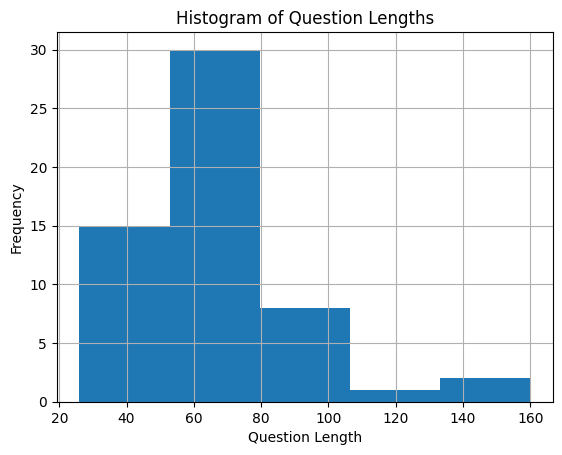

In [ ]:
# Length
questions = all_result_df["question"].to_list()
question_len = pd.DataFrame([len(q) for q in questions], columns=["length"])
question_len.hist(bins=5)
plt.title("Histogram of Question Lengths")
plt.xlabel("Question Length")
plt.ylabel("Frequency")
plt.show()

In addition to visual representation, we also want to look at more concrete percentile values.


In [ ]:
# Calculating percentile values
p10 = int(question_len["length"].quantile(0.10))
p90 = int(question_len["length"].quantile(0.90))
print("p10-p90 range is", p90 - p10)

p10-p90 range is 46


There are also a couple queries that are longer than normal. However, these seem fine.

In [ ]:
[q for q in questions if len(q) > 100]

['What is a common configuration for lowering the total memory pressure for pytorch models within transformers pipelines?',
 'How can you get all active runs from experiments IDs 3, 4, and 17 that used a CNN model with 10 layers and had a prediction accuracy of 94.5% or higher?',
 'What interfaces does the MLflow client use to record MLflow entities and artifacts when running MLflow on a local machine with a SQLAlchemy-compatible database?']

#### Latent Space

Latent space embeddings contain semantic information about the question. This can be used to 
evaluate the diversity and the difference between two questions semantically. To do so, we will need to map the
high dimensional space to a lower dimensional space. We utilize PCA and TSNE to map the embeddings 
into a 2-dimensional space for visualization.

We append 5 benchmark queries to help visualize how diverse the questions are. The first four of these questions are semantically similar and all asking about MLflow, while the last is different and asks about RAG.

In [ ]:
benchmark_questions = [
    "What is MLflow?",
    "What is MLflow about?",
    "What is MLflow Tracking?",
    "What is MLflow Evaluation?",
    "Why is RAG so popular?",
]
questions_to_embed = questions + benchmark_questions

We apply PCA to reduce the embedding dimensions to 10 before applying TSNE to reduce it to 2 dimensions, as recommended by sklearn due to the computational complexity of TSNE.

In [ ]:
# Apply embeddings
embeddings = OpenAIEmbeddings()
question_embeddings = embeddings.embed_documents(questions_to_embed)
# PCA on embeddings to reduce to 10-dim
pca = PCA(n_components=10)
question_embeddings_reduced = pca.fit_transform(question_embeddings)
# TSNE on embeddings to reduce to 2-dim
tsne = TSNE(n_components=2, random_state=SEED)
lower_dim_embeddings = tsne.fit_transform(question_embeddings_reduced)

Now that we have 2-dimensional embeddings representing the semantics of the question, we can visualize it with a scatter plot, differentiating the generated questions and the benchmark questions.

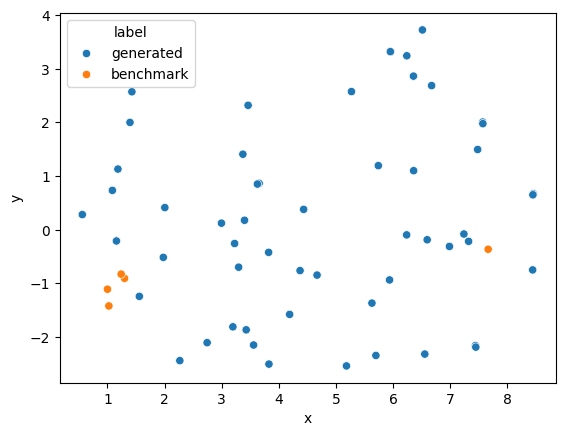

In [ ]:
labels = np.concatenate(
    [
        np.full(len(lower_dim_embeddings) - len(benchmark_questions), "generated"),
        np.full(len(benchmark_questions), "benchmark"),
    ]
)
data = pd.DataFrame(
    {"x": lower_dim_embeddings[:, 0], "y": lower_dim_embeddings[:, 1], "label": labels}
)
sns.scatterplot(data=data, x="x", y="y", hue="label")

Observe that within the orange points on the scatter plot, there is one point that is further than the others. That is the unique benchmark question about RAG. This plot gives a sense of the diversity of the questions generated.

### Evaluate Document Relevance

Another important axis to consider is how relevant the questions are to the document we provided. We want to understand whether the questions generated by the LLM is actually referring to our provided text, or whether it is hallucinating irrelevant questions. We will evaluate relevance by first manually checking certain questions against their document chunk. Then, we define a measure of relevance to analyze it quantitatively.

#### Manual Checking of Document Relevance

Manual qualitative check of whether the questions are relevant to the document.

In [ ]:
all_result_df.sample(3)

,question,answer,chunk,chunk_id,source
27,What is an MLflow Project?,An MLflow Project is a format for packaging da...,Documentation MLflow Projects MLflow Projects ...,0,projects.html
54,What information does autologging capture when...,Autologging captures the following information...,when launching short-lived MLflow runs that re...,21,tracking.html
38,What is the syntax for searching runs using th...,The syntax for searching runs using the MLflow...,Documentation Search Runs Search Runs The MLfl...,0,search-runs.html


#### Embeddings Cosine Similarity

The embedding of the chunk and query is placed in the same latent space, and the retriever model would extract similar chunk embeddings to a query embedding. Hence, relevance for the retriever is defined by the distance of embeddings in this latent space.

Cosine similarity is a measure of vector similarity, and can be used to determine the distance of embeddings between the chunk and the query. It is a distance metric that approaches 1 when the question and chunk are similar, and becomes 0 when they are different.

We can use the cosine similarity score directly to measure the relevancy.

In [ ]:
embedded_queries = all_result_df.copy()
embedded_queries["chunk_emb"] = all_result_df["chunk"].apply(
    lambda x: np.squeeze(cached_langchain_openai_embeddings(chunk=x, cache=embeddings_cache))
)
embedded_queries["question_emb"] = all_result_df["question"].apply(
    lambda x: np.squeeze(cached_langchain_openai_embeddings(chunk=x, cache=embeddings_cache))
)

In [ ]:
def cossim(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))


embedded_queries["cossim"] = embedded_queries.apply(
    lambda row: cossim(row["question_emb"], row["chunk_emb"]), axis=1
)

After we score each question by its relative relevancy, we can evaluate the generated questions as a whole.

(array([ 1.,  8., 15., 20., 12.]),
 array([0.72730601, 0.76292693, 0.79854785, 0.83416876, 0.86978968,
        0.9054106 ]),
 <BarContainer object of 5 artists>)

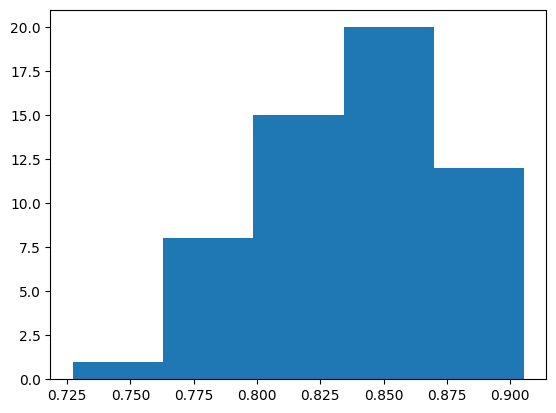

In [ ]:
scores = embedded_queries["cossim"].to_list()
plt.hist(scores, bins=5)

There are a couple lower scores. Let's take a look at them.

In [ ]:
mask = embedded_queries["cossim"] < 0.75
lower_cossim = embedded_queries[mask]
for i, row in lower_cossim.iterrows():
    print(f"Question: {i}")
    print(row["question"])
    print("Chunk:")
    print(row["chunk"])
    print("cossim:")
    print(row["cossim"])

Question: 45
What is the purpose of the 'experimentIds' variable in the given paragraph?
Chunk:
API. List<Long> experimentIds = Arrays.asList("1", "2", "4", "8"); List<RunInfo> searchResult = client.searchRuns(experimentIds, "metrics.accuracy_score < 99.90"); Previous Next © MLflow Project, a Series of LF Projects, LLC. All rights reserved.
cossim:
0.7273060141018568


Manual inspection of these less relevant questions reveals that some chunks are less informative or mainly consists of code, hence the generated question might be less useful. You can choose to filter these as desired.